<a href="https://colab.research.google.com/github/jan-felix/SLOG/blob/master/Metculus_and_Dawum_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import pandas as pd
import ergo
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

/usr/local/lib/python3.7/dist-packages/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
metaculus = ergo.Metaculus()

# Get Predictions

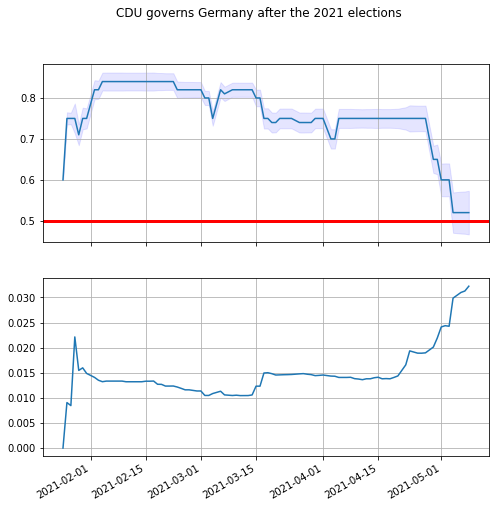

In [4]:
my_pred = 0.5
question_id = 6338
question_name = "CDU governs Germany after the 2021 elections"
#def metaculus_question_plot(question_id,question_name,my_pred):

binary="yes"

#Retrieve and Format Data
question = metaculus.get_question(question_id, name=question_name)
title = question.data["title"]
n_predictions = question.data["number_of_predictions"]
data_hist = question.data["prediction_histogram"]

data_ts = pd.DataFrame(question.data["prediction_timeseries"])
data_ts.index = pd.to_datetime(data_ts["t"],unit="s")
data_ts.index = pd.DatetimeIndex(data_ts.index.strftime('%Y-%m-%d'))
data_ts.index.name = None
data_ts = data_ts.drop(columns="t")
data_ts = data_ts.groupby(data_ts.index).last()

hist_dist = pd.DataFrame(data_ts["distribution"].tolist())
hist_dist = hist_dist.drop(columns = "num")
hist_dist.index = data_ts.index
hist_dist = hist_dist.groupby(hist_dist.index).last()

data_ts["Upper90"] = 1.65*hist_dist["var"]+data_ts["community_prediction"]
data_ts["Lower90"] = -1.65*hist_dist["var"]+data_ts["community_prediction"]

fig, axs = plt.subplots(2,1,figsize =(8,8),sharex=True)
fig.suptitle(question_name)
axs[0].plot(data_ts["community_prediction"])
axs[0].fill_between(data_ts["community_prediction"].index, data_ts["Lower90"], data_ts["Upper90"], color='b', alpha=.1)
axs[0].grid()
axs[0].axhline(my_pred, linewidth=3, color='r')
axs[1].plot(hist_dist["var"])
axs[1].grid()
fig.autofmt_xdate()

# Get recent Dawum Data

In [5]:
table_dawum_verlauf = pd.read_html('https://dawum.de/Bundestag/#Umfrageverlauf')
recent_polls = pd.DataFrame(table_dawum_verlauf[0]).set_index(0).dropna(axis=1)
recent_polls.columns = ["Current","Change"]
recent_polls.index.name = None
recent_polls

,Current,Change
Grüne,"25,9%","(+0,7)"
CDU/CSU,"24,3%","(−1,0)"
SPD,"14,4%","(−0,1)"
FDP,"11,1%","(+0,3)"
AfD,"10,7%","(+0,1)"
Linke,"6,6%","(−0,6)"
Freie Wähler,"2,6%",(—)


In [6]:
meta_poll_data = pd.DataFrame(table_dawum_verlauf[1]).set_index(0)
meta_poll_data.columns = ["Value"]
meta_poll_data.index.name = None
meta_poll_data

,Value
Durchschnitt:,7 Wahlumfragen
Gewichtung:,letzter Befragungstag
Veröffentlichung:,30.04. - 07.05.
Befragte:,20316
Vergleich:,zum 30.04.


# Scrape Dawum Chronik

In [37]:
URL = 'https://dawum.de/Bundestag/#Vergleich_mit_Wahlergebnis'
page = requests.get(URL)
#Get Soup
soup = BeautifulSoup(page.content, 'html.parser')
chronik = soup.find(id="Chronik")
table = chronik.find("div",attrs={"class": "table"})
#Create Table
df = pd.DataFrame()
rows = table.findAll("a")
table_list = []
for row in rows: 
  cols = row.findAll("div")
  row_list = []
  for div in cols:
    row_list.append(div.get_text())
  table_list.append(row_list)

#Format Data 
rawr_data = pd.DataFrame(table_list)
dates = rawr_data[0].str[0:10]
institute =rawr_data[0].str[10:]

rawr_data.columns = ["Institute","Union","Greens","SPD","AFD","FDP","Linke","Freie Wähler","Sonstige"]

institute = institute.str.replace('\xad', '') 
institute = [s.strip() for s in institute]
rawr_data["Institute"] = institute
rawr_data.index = pd.DatetimeIndex(pd.to_datetime(dates, dayfirst = True))
rawr_data.index.name = None

cols = ["Union","Greens","SPD","AFD","FDP","Linke","Sonstige"]
rawr_data[cols] = rawr_data[cols].apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)
rawr_data = rawr_data.sort_index()

rawr_data = rawr_data.ewm(halflife = 3).mean()
comparison_df = pd.DataFrame()
comparison_df["Union_Green_Gap"] = rawr_data["Union"]-rawr_data["Greens"]
comparison_df= pd.merge(comparison_df, data_ts["community_prediction"], left_index=True, right_index=True)


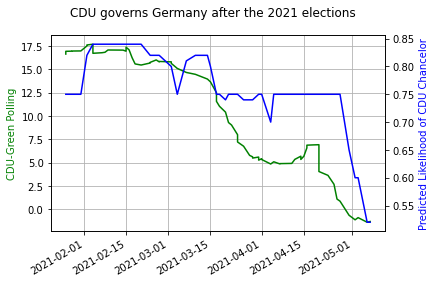

In [63]:

fig, axs = plt.subplots()
fig.suptitle(question_name)
axs.plot(comparison_df["Union_Green_Gap"], "green")
axs.set_ylabel("CDU-Green Polling", color="green")
axs.grid()
axs1 = axs.twinx()
axs1.plot(comparison_df["community_prediction"], "blue")
axs1.set_ylabel("Predicted Likelihood of CDU Chancelor", color="blue")
fig.autofmt_xdate()

